# KNN and SVM Models from Pretrained Embedding Models

### 1) Load Dependencies 

In [1]:
import os
import cv2
import pandas as pd
import torch
import random
import timm
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision import models
from concurrent.futures import ThreadPoolExecutor
from torchvision import transforms
from itertools import islice
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
from collections import defaultdict
# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 2) Load Data

In [2]:
# Load tensors
print("Loading Data")

train_val_images = torch.load("/teamspace/studios/written-violet-bdv7/train_images.pt")
print("Training/Validation Images Loaded")
print(f"Loaded Training/Validation Images Shape: {train_val_images.shape}")
X_train = train_val_images.to(device)

train_val_labels = torch.load("/teamspace/studios/written-violet-bdv7/train_labels.pt")
print("Training/Validation Labels Loaded")
print(f"Loaded Training/Validation Labels Shape: {train_val_labels.shape}")
y_train = train_val_labels.to(device)

holdout_images = torch.load("/teamspace/studios/written-violet-bdv7/holdout2_images.pt")
print("Holdout Images Loaded")
print(f"Loaded Holdout Images Shape: {train_val_images.shape}")
X_test = holdout_images.to(device)

holdout_labels = torch.load("/teamspace/studios/written-violet-bdv7/holdout2_labels.pt")
print("Holdout Labels Loaded")
print(f"Loaded Holdout Labels Shape: {train_val_labels.shape}")
y_test = holdout_labels.to(device)

# Get unique labels and their counts
unique_labels, label_counts = torch.unique(y_train, return_counts=True)

# Display label counts
for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label.item()}, Count: {count.item()}")

Loading Data
Training/Validation Images Loaded
Loaded Training/Validation Images Shape: torch.Size([34268, 3, 256, 256])
Training/Validation Labels Loaded
Loaded Training/Validation Labels Shape: torch.Size([34268])
Holdout Images Loaded
Loaded Holdout Images Shape: torch.Size([34268, 3, 256, 256])
Holdout Labels Loaded
Loaded Holdout Labels Shape: torch.Size([34268])
Label: 0, Count: 17134
Label: 1, Count: 17134


In [3]:
# DataLoader for batching
batch_size = 64
classifiertrain_dataset = TensorDataset(X_train, y_train)
classifiertrain_loader = DataLoader(classifiertrain_dataset, batch_size=batch_size, shuffle=True)

classifiertest_dataset = TensorDataset(X_test, y_test)
classifiertest_loader = DataLoader(classifiertest_dataset, batch_size=batch_size)

### 3) Define Embedding Models (Trained in another book with embedding size 128)
**Trained to minimize triplet margin loss (metric learning loss)**
- ResNet-18
- EfficientNet
- NasNetLarge

In [4]:
def ResNet18_TML(embed_dim=128):
    model = models.resnet18(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Input features are fixed for ResNet18
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, embed_dim),
    )

    return model.to(device)


In [5]:
def EfficientNet_TML(embed_dim=128):
    model = models.efficientnet_b0(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for name, param in model.named_parameters():
        if "features.6" in name or "features.7" in name or "features.8" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False


    # Customize the fully connected layer
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, embed_dim),
    )

    return model.to(device)


In [6]:
def NasNetLarge_TML(embedding_size=128):
    model = timm.create_model('nasnetalarge', pretrained=True)

    # fine-tune deeper layers
    for name, param in model.named_parameters():
        if "cell_17" in name or "cell_18" in name or "cell_19" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # custom fully connected layer
    model.last_linear = nn.Sequential(
        nn.Linear(model.num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, embedding_size),
    )


    return model.to(device)

### 4) Define a function to extract embeddings used as inputs for the KNNs and SVMs

In [7]:
def extract_embeddings(dataloader, model):
    """
    Extract embeddings and their corresponding labels from a dataloader using the model.

    Args:
        dataloader (DataLoader): DataLoader object for the dataset.
        model (torch.nn.Module): Trained model to extract embeddings.

    Returns:
        embeddings (torch.Tensor): Tensor of embeddings with shape (num_samples, embed_dim).
        labels (torch.Tensor): Tensor of corresponding labels with shape (num_samples,).
    """
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_labels = []

    with torch.no_grad():  # No need for gradients during inference
        for batch in dataloader:
            # Unpack the batch
            data, labels = batch  # Regular data and labels

            # Move data to the same device as the model
            data = data.to(next(model.parameters()).device)

            # Get embeddings
            embeddings = model(data)

            # Append results
            all_embeddings.append(embeddings.cpu())  # Move to CPU for compatibility with sklearn
            all_labels.append(labels.cpu())

    # Concatenate all embeddings and labels into tensors
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_embeddings, all_labels


### 5) Train Final KNNs and SVCs to test on holdout set (optimal Ks and Cs found in another book)

#### a. ResNet18

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fitting KNN with K = 10
Accuracy on the holdout dataset: 0.7308%
Weighted Precision on the holdout dataset: 0.7318
              precision    recall  f1-score   support

     Class 0       0.72      0.76      0.74      5718
     Class 1       0.75      0.70      0.72      5703

    accuracy                           0.73     11421
   macro avg       0.73      0.73      0.73     11421
weighted avg       0.73      0.73      0.73     11421

Average Precision Score: 0.6718904793630649


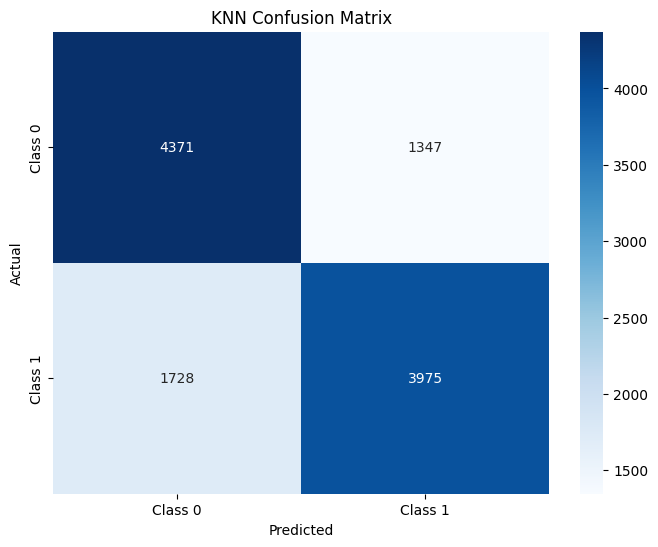

In [8]:
# Extract embeddings and train KNN
embeddingmodel = ResNet18_TML(128)
embeddingmodel.load_state_dict(torch.load("resnet18_embedder.pt"))

train_embeddings, train_labels = extract_embeddings(classifiertrain_loader, embeddingmodel)
test_embeddings, test_labels = extract_embeddings(classifiertest_loader, embeddingmodel)

k = 10
knn = KNeighborsClassifier(n_neighbors=k)
print(f"Fitting KNN with K = {k}")
knn.fit(train_embeddings, train_labels)

# Evaluate
test_preds = knn.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)
weighted_precision = precision_score(test_labels, test_preds, average='weighted')

print(f"Accuracy on the holdout dataset: {accuracy:.4f}%")
print(f"Weighted Precision on the holdout dataset: {weighted_precision:.4f}")


# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

Fitting SVC with C = 1487


Accuracy on the holdout dataset: 0.7344%
Weighted Precision on the holdout dataset: 0.7347
              precision    recall  f1-score   support

     Class 0       0.73      0.75      0.74      5718
     Class 1       0.74      0.72      0.73      5703

    accuracy                           0.73     11421
   macro avg       0.73      0.73      0.73     11421
weighted avg       0.73      0.73      0.73     11421

Average Precision Score: 0.6736561913262834


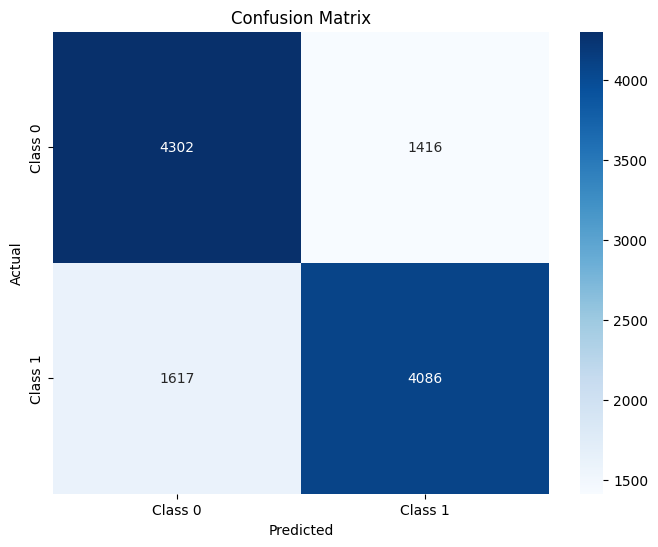

In [9]:
C = 1487
svc = SVC(C=C)
print(f"Fitting SVC with C = {C}")
svc.fit(train_embeddings, train_labels)

# Evaluate
test_preds = svc.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)
weighted_precision = precision_score(test_labels, test_preds, average='weighted')

print(f"Accuracy on the holdout dataset: {accuracy:.4f}%")
print(f"Weighted Precision on the holdout dataset: {weighted_precision:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### b. EfficientNet

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fitting KNN with K = 86
Accuracy on the holdout dataset: 0.7529%
Weighted Precision on the holdout dataset: 0.7529
              precision    recall  f1-score   support

     Class 0       0.75      0.75      0.75      5718
     Class 1       0.75      0.75      0.75      5703

    accuracy                           0.75     11421
   macro avg       0.75      0.75      0.75     11421
weighted avg       0.75      0.75      0.75     11421

Average Precision Score: 0.6899974221433608


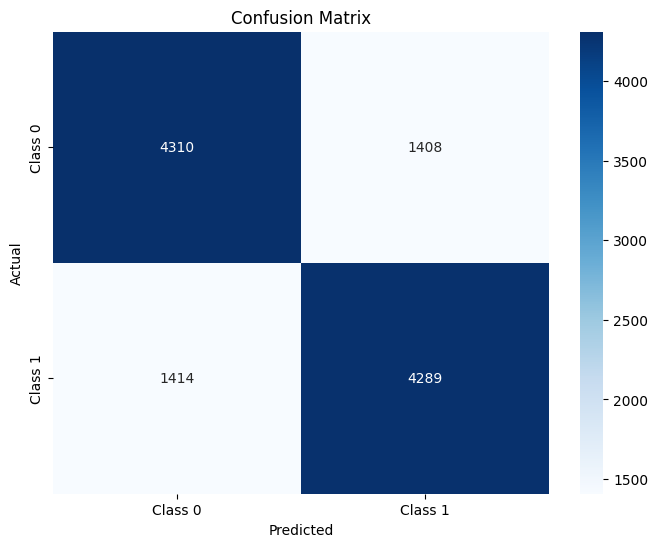

In [10]:
# Extract embeddings and train KNN
embeddingmodel = EfficientNet_TML(128)
embeddingmodel.load_state_dict(torch.load("efficientnet_embedder.pt"))

train_embeddings, train_labels = extract_embeddings(classifiertrain_loader, embeddingmodel)
test_embeddings, test_labels = extract_embeddings(classifiertest_loader, embeddingmodel)


k = 86
knn = KNeighborsClassifier(n_neighbors=k)
print(f"Fitting KNN with K = {k}")
knn.fit(train_embeddings, train_labels)

# Evaluate
test_preds = knn.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)
weighted_precision = precision_score(test_labels, test_preds, average='weighted')

print(f"Accuracy on the holdout dataset: {accuracy:.4f}%")
print(f"Weighted Precision on the holdout dataset: {weighted_precision:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Fitting SVC with C = 0.001269


Accuracy on the holdout dataset: 0.7533%
Weighted Precision on the holdout dataset: 0.7533
              precision    recall  f1-score   support

     Class 0       0.75      0.75      0.75      5718
     Class 1       0.75      0.75      0.75      5703

    accuracy                           0.75     11421
   macro avg       0.75      0.75      0.75     11421
weighted avg       0.75      0.75      0.75     11421

Average Precision Score: 0.6900610067960443
Accuracy: 0.7532615357674459


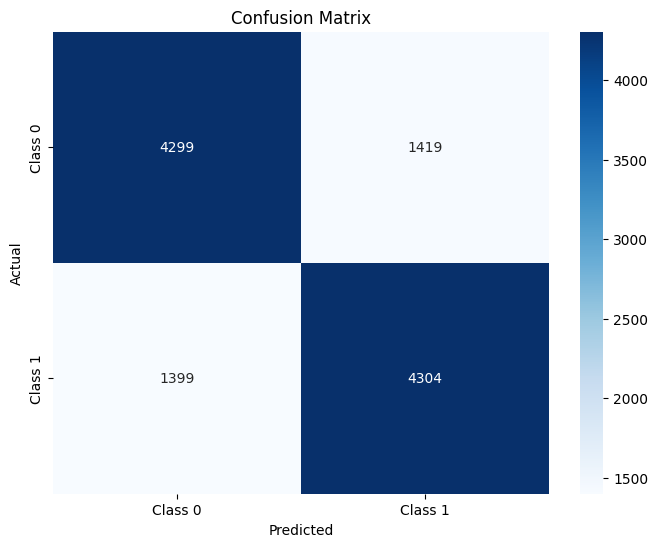

In [11]:
# Try both 0.001269 and 788 for C
C = 0.001269
svc = SVC(C=C)
print(f"Fitting SVC with C = {C}")
svc.fit(train_embeddings, train_labels)

# Evaluate
test_preds = svc.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)
weighted_precision = precision_score(test_labels, test_preds, average='weighted')

print(f"Accuracy on the holdout dataset: {accuracy:.4f}%")
print(f"Weighted Precision on the holdout dataset: {weighted_precision:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")
print(f"Accuracy: {accuracy}")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### c. NasNetLarge

Fitting KNN with K = 81
Accuracy on the holdout dataset: 0.7272%
Weighted Precision on the holdout dataset: 0.7272
              precision    recall  f1-score   support

     Class 0       0.73      0.72      0.73      5718
     Class 1       0.72      0.73      0.73      5703

    accuracy                           0.73     11421
   macro avg       0.73      0.73      0.73     11421
weighted avg       0.73      0.73      0.73     11421

Average Precision Score: 0.6639966520036674


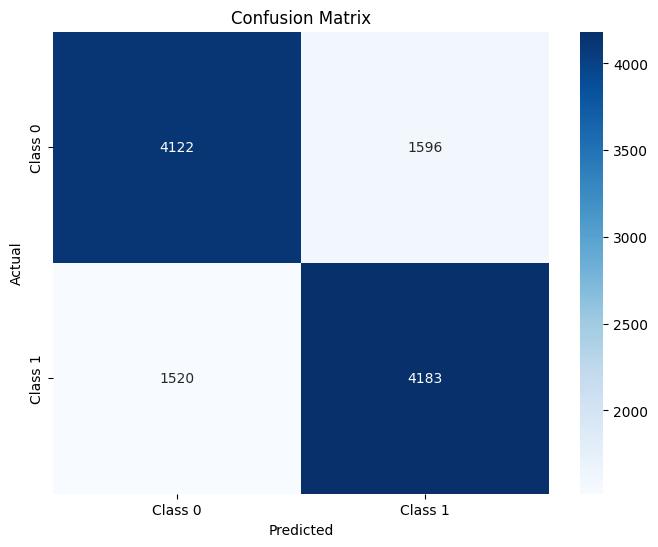

In [12]:
# Extract embeddings and train KNN
embeddingmodel = NasNetLarge_TML(128)
embeddingmodel.load_state_dict(torch.load("nasnet_embedder.pt"))

train_embeddings, train_labels = extract_embeddings(classifiertrain_loader, embeddingmodel)
test_embeddings, test_labels = extract_embeddings(classifiertest_loader, embeddingmodel)


k = 81
knn = KNeighborsClassifier(n_neighbors=k)
print(f"Fitting KNN with K = {k}")
knn.fit(train_embeddings, train_labels)

# Evaluate
test_preds = knn.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)
weighted_precision = precision_score(test_labels, test_preds, average='weighted')

print(f"Accuracy on the holdout dataset: {accuracy:.4f}%")
print(f"Weighted Precision on the holdout dataset: {weighted_precision:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Fitting SVC with C = 0.03039


Accuracy on the holdout dataset: 0.7284%
Weighted Precision on the holdout dataset: 0.7284
              precision    recall  f1-score   support

     Class 0       0.73      0.73      0.73      5718
     Class 1       0.73      0.73      0.73      5703

    accuracy                           0.73     11421
   macro avg       0.73      0.73      0.73     11421
weighted avg       0.73      0.73      0.73     11421

Average Precision Score: 0.6658235013612032


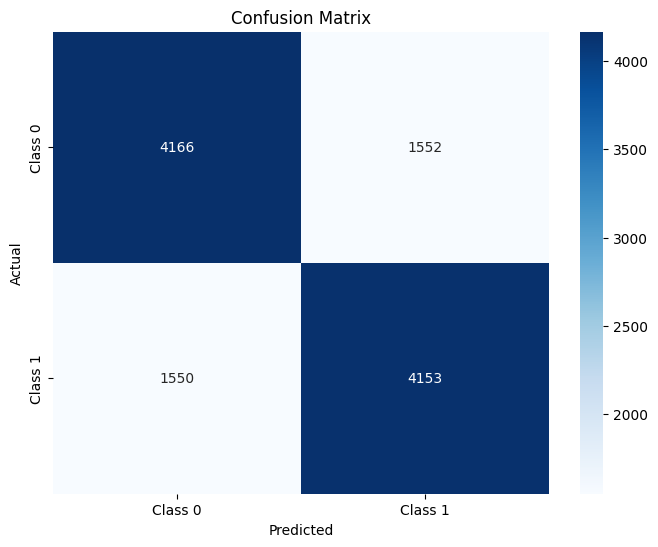

In [13]:
C = 0.03039
svc = SVC(C=C)
print(f"Fitting SVC with C = {C}")
svc.fit(train_embeddings, train_labels)

# Evaluate
test_preds = svc.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_preds)
weighted_precision = precision_score(test_labels, test_preds, average='weighted')

print(f"Accuracy on the holdout dataset: {accuracy:.4f}%")
print(f"Weighted Precision on the holdout dataset: {weighted_precision:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Calculate precision, recall, and F1-score
report = classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"])
print(report)
aps = average_precision_score(test_labels, test_preds)
print(f"Average Precision Score: {aps}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()